In [1]:
import string
from collections import Counter

import torch
import torch.nn.init as init
import torch.nn as nn
import pandas as pd
import numpy as np

In [2]:
with open('../sentiment-rnn/data/reviews.txt','r') as file:
    review = file.readlines()
with open('../sentiment-rnn/data/labels.txt','r') as file:
    labels = file.readlines()

In [3]:
raw_rdc = pd.DataFrame({'REVIEWS':review,'LABELS':labels})
raw_rdc.head(3)

,REVIEWS,LABELS
0,bromwell high is a cartoon comedy . it ran at ...,positive\n
1,story of a man who has unnatural feelings for ...,negative\n
2,homelessness or houselessness as george carli...,positive\n


In [4]:
def standardize_column_values(data: pd.DataFrame, columns: list) -> pd.DataFrame:
    trans = str.maketrans('', '', string.punctuation)  # Pre-create translation table
    for col in columns:
        data[col] = data[col].str.lower().str.translate(trans)  # Combine vectorized string operations
    return data.copy()  # Return a copy to avoid modifying the original DataFrame

In [5]:
rdc = standardize_column_values(raw_rdc,columns=['REVIEWS','LABELS'])
rdc['POSITIVE'] = np.where(rdc.LABELS.str.lower()=='positive\n',1,0)
rdc.head()

,REVIEWS,LABELS,POSITIVE
0,bromwell high is a cartoon comedy it ran at t...,positive\n,1
1,story of a man who has unnatural feelings for ...,negative\n,0
2,homelessness or houselessness as george carli...,positive\n,1
3,airport starts as a brand new luxury pla...,negative\n,0
4,brilliant over acting by lesley ann warren b...,positive\n,1


In [6]:
from collections import Counter

In [7]:
# Create Encodings
cntr = Counter(''.join(rdc.REVIEWS.to_list()).split())
vocab = sorted(cntr,key = cntr.get, reverse=True)
encoding = {word:code for code,word in enumerate(vocab,1)}

In [8]:
def encode(review:str, encoding:dict=encoding):
    return [encoding[word] for word in review.split() if word not in string.whitespace]

def create_padded_encoding(string:str,encoding:dict=encoding,seq_len:int=256)->str:
    padding = seq_len - len(string.split())
    if padding <= 0:
        return encode(' '.join(string.split()[:seq_len]))
    else:
        return encode(string)+list(np.zeros(padding))

In [9]:
rdc.REVIEWS.str.len().describe()

count    25000.000000
mean      1334.043000
std       1007.516843
min         55.000000
25%        708.000000
50%        986.000000
75%       1622.000000
max      13741.000000
Name: REVIEWS, dtype: float64

In [10]:
threshold = rdc.REVIEWS.str.len().mean() + 3 * rdc.REVIEWS.str.len().std()

In [11]:
select_reveiws = rdc[rdc.REVIEWS.str.len()<threshold]

In [12]:
select_reveiws.loc[:,'ENCODED_REVIEW'] = rdc.REVIEWS.apply(lambda x:create_padded_encoding(x,encoding=encode,seq_len=258))
select_reveiws = select_reveiws[['ENCODED_REVIEW','POSITIVE']]
select_reveiws.head()

/var/folders/5f/5zjyy8xn5yd__x_zmgn518_c0000gn/T/ipykernel_2903/2434981666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_reveiws.loc[:,'ENCODED_REVIEW'] = rdc.REVIEWS.apply(lambda x:create_padded_encoding(x,encoding=encode,seq_len=258))


,ENCODED_REVIEW,POSITIVE
0,"[21025, 308, 6, 3, 1050, 207, 8, 2138, 32, 1, ...",1
1,"[63, 4, 3, 125, 36, 47, 7472, 1395, 16, 3, 418...",0
2,"[22382, 42, 46418, 15, 706, 17139, 3389, 47, 7...",1
4,"[520, 119, 113, 34, 16372, 1816, 3737, 117, 88...",1
5,"[11, 20, 3637, 141, 10, 422, 23, 272, 60, 4355...",0


In [13]:
split_frac = 0.8

from sklearn.model_selection import train_test_split

train_reviews,test_reviews,train_labels,test_labels = train_test_split(select_reveiws.ENCODED_REVIEW,select_reveiws.POSITIVE,test_size=0.2)
val_reviews,test_reviews,val_labels,test_labels = train_test_split(test_reviews,test_labels,test_size=0.5)

In [14]:
train_reviews.shape, val_reviews.shape, test_reviews.shape

((19540,), (2442,), (2443,))

In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.tensor(train_reviews.to_list(),dtype=int), torch.tensor(train_labels.to_list(),dtype=int))
valid_data = TensorDataset(torch.tensor(val_reviews.to_list(),dtype=int), torch.tensor(val_labels.to_list(),dtype=int))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [16]:
# Obtain one batch of training data using iter and next
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size())  # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size())  # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([128, 258])
Sample input: 
 tensor([[15089, 14800,     6,  ...,     0,     0,     0],
        [ 2925,     4,     1,  ...,  2637,   424,    23],
        [   10,   216,    11,  ...,     0,     0,     0],
        ...,
        [  428,     4,   212,  ...,     0,     0,     0],
        [67352,   906,  1888,  ...,   516,     1,  3356],
        [   10,   563,     5,  ...,    23,  3009,     8]])

Sample label size:  torch.Size([128])
Sample label: 
 tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0])


## $\text{Model}$

In [17]:
from torch.nn import Linear,Embedding,LSTM,Sigmoid,Dropout
import torch
import torch.functional as F

class SentimentClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_nodes, hidden_dim, num_class, num_layers) -> None:
        super().__init__()

        self.embedding_layer = Embedding(num_embeddings=vocab_size,embedding_dim=embedding_nodes)
        self.lstm = LSTM(
                            input_size = embedding_nodes,
                            hidden_size = hidden_dim,
                            num_layers = num_layers,
                            batch_first = True,
                            dropout = 0.4
                        )
        self.dropout = Dropout(p=0.3)
        self.dense = Linear(in_features=hidden_dim,out_features=num_class)
        self.sigmoid = Sigmoid()

    def forward(self,x):
        output = self.embedding_layer(x)
        output,(hidden,cell) = self.lstm(output)
        # output dim = [N,L,H]; N is batch_size, L is lenght, H is hidden_dim
        output = output[:,-1,:] #Its indexing; the first : says pick all N, then last L, and all H
        output = self.dropout(output)
        output = self.dense(output)
        output = self.sigmoid(output)
        return output

## $\text{Model Training Loop}$

In [19]:
def val_loop(model, val_loader, criterion, batch_size):
    metal_device = torch.device('mps')
    criterion = criterion.to(metal_device)
    model.eval()
    total_loss = 0.0
    num_samples = 0
    for val_review, val_label in val_loader:
        if val_review.size(0) < batch_size:
            break
        val_review = val_review.to(metal_device)
        val_label = val_label.to(metal_device)
        val_label = val_label.float()

        with torch.no_grad():
            pred = model(val_review)
            loss = criterion(pred, val_label.unsqueeze(1))
            total_loss += loss.item() * val_review.size(0)
            num_samples += val_review.size(0)
    model.train()
    return total_loss / num_samples

In [20]:
def train_loop(model,train_loader,criterion,optimizer,batch_size):
    metal_device = torch.device('mps')
    model = model.to(metal_device)
    criterion = criterion.to(metal_device)
    total_loss = 0.0
    num_samples = 0
    # if hidden == None:
    #     hidden = model.init_hidden(batch_size)
    for review,label in train_loader:
        if review.size(0) < batch_size:
            break
        review = review.to(metal_device)
        label = label.to(metal_device)
        model.zero_grad()
        # hidden = tuple([layer.data for layer in hidden])
        pred = model.forward(review)
        label = label.float()
        # print(pred, label)
        loss = criterion(pred,label.unsqueeze(1))
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(),10)

        optimizer.step()
        total_loss += loss.item() * review.size(0)
        num_samples += review.size(0)
    return total_loss / num_samples

In [21]:
vocab_size = len(vocab)+1
output_size = 1
embedding_dim = 500
hidden_dim = 256
n_layers = 1

In [22]:
net = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, output_size, n_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

print(net)

/Users/aditya/miniconda3/envs/PyTorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


SentimentClassifier(
  (embedding_layer): Embedding(74073, 500)
  (lstm): LSTM(500, 256, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.3, inplace=False)
  (dense): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [23]:
metal_device = torch.device('mps')
net = net.to(metal_device)
# hidden = net.init_hidden(batch_size)
for epoch in range(5):
    train_loss = train_loop(net,train_loader,criterion,optimizer,batch_size)
    val_loss = val_loop(net,val_loader=valid_loader,criterion=criterion,batch_size=batch_size)
    print(f'Epoch: {epoch+1}; Train Loss: {train_loss:.2f}; Validation Loss: {val_loss:.2f}')

Epoch: 1; Train Loss: 0.70; Validation Loss: 0.69
Epoch: 2; Train Loss: 0.67; Validation Loss: 0.69
Epoch: 3; Train Loss: 0.58; Validation Loss: 0.61
Epoch: 4; Train Loss: 0.41; Validation Loss: 0.53
Epoch: 5; Train Loss: 0.29; Validation Loss: 0.49


In [24]:
def classifiy(model, data:pd.DataFrame()):
    test_data = torch.tensor(data.to_list(),dtype=int)
    metal_device = torch.device('mps')
    test_data = test_data.to(metal_device)
    model = model.to(metal_device)
    with torch.no_grad():
        pred = model.forward(test_data)
    return pred.cpu().numpy().round()

In [25]:
torch.mps.empty_cache()

In [26]:
preds = classifiy(net,test_reviews)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score

Accuracy: 0.79
F1 Score: 0.78
Precision: 0.80
Recall: 0.77


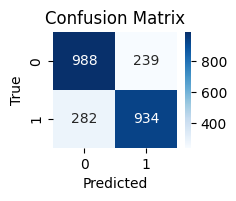

In [28]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, preds.round())
print(f"Accuracy: {accuracy_score(test_labels,preds):.2f}")
print(f"F1 Score: {f1_score(test_labels,preds):.2f}")
print(f"Precision: {precision_score(test_labels,preds):.2f}")
print(f"Recall: {recall_score(test_labels,preds):.2f}")
# Plot confusion matrix using Seaborn
plt.figure(figsize=(2, 1.5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()